# Time series analysis

## Imports

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import requests 
import json
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')
style.use('ggplot')

# Get trading data for BTCUSD

Request from Binance API symbol's with hourly interval and create a df.
Increasing the range gives us further data in the past.

In [34]:
df_btcusd = pd.read_csv('./data_arima/btcusd.csv', index_col=0)

In [35]:
df_btcusd.head()

,Open,High,Low,Close,Volume,Date
Time,,,,,,
1584453600000,5090.11,5245.08,5051.00,5223.47,7312.312383,2020-03-17 14:00:00
1584450000000,5206.25,5322.41,5071.80,5090.11,9510.615003,2020-03-17 13:00:00
1584446400000,5266.90,5350.00,5175.00,5206.25,5782.963584,2020-03-17 12:00:00
1584442800000,5295.00,5325.74,5229.08,5267.61,4340.171558,2020-03-17 11:00:00
1584439200000,5227.55,5305.00,5214.00,5293.45,3965.023835,2020-03-17 10:00:00


In [36]:
timeseries = df_btcusd.groupby('Date')['Close'].mean()
timeseries.head()

Date
2019-12-04 08:00:00    7180.92
2019-12-04 09:00:00    7192.01
2019-12-04 10:00:00    7222.66
2019-12-04 11:00:00    7200.34
2019-12-04 12:00:00    7217.65
Name: Close, dtype: float64

In [37]:
df = pd.DataFrame(timeseries)
df.tail()

,Close
Date,
2020-03-17 10:00:00,5293.45
2020-03-17 11:00:00,5267.61
2020-03-17 12:00:00,5206.25
2020-03-17 13:00:00,5090.11
2020-03-17 14:00:00,5223.47


As we can see the 2020-03-12 at 09:00:00 the prices due to the corona virus are suffering a fall.

I am for this reason removing the data after that point going forward.

In [38]:
df.index = pd.to_datetime(df.index)

In [39]:
df = df[df.index < '2020-03-12 09:00:00']
df.tail()

,Close
Date,
2020-03-12 04:00:00,7624.30
2020-03-12 05:00:00,7646.95
2020-03-12 06:00:00,7494.17
2020-03-12 07:00:00,7392.13
2020-03-12 08:00:00,7377.64


# Create training and test data

We are looking to predict 3 days forward or 72 hours.

In [40]:
len(df) - 72

2298

In [41]:
train = df.Close[:len(df) - 72]
test = df.Close[len(df) - 72:]

In [42]:
def arimamodel(timeseries):
    '''
     Creating the model: automatic ARIMA using ADF to test stationarity, 
     start values for p and q are set to 1, and the crypto data is not assumed to be seasonal 
 
     Args: 
         timeseries: Pandas timeseries with closing price 
         
     Returns: 
         automodel: automatic ARIMA model
    '''
    automodel = pm.auto_arima(df, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [43]:
def plotarima(n_periods, timeseries, automodel):
    ''' 
    Plot ARIMA forecast using statsmodel’s plot_predict, 
        filling the area between the upper and lower prediction bounds.
    
    Args: 
        n_periods: steps for the forecast
        timeseries: Pandas timeseries with closing price 
        automodel: automatic ARIMA model
    '''
    # Hourly index
    fc_ind = pd.date_range(df.index[df.shape[0]-1], 
                           periods=n_periods, freq="h")
    # Forecast series
    fc_series = pd.Series(forecast[0], index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(forecast[2][:,0], index=fc_ind)
    upper_series = pd.Series(forecast[2][:,1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(df)
    plt.plot(fc_series, color="blue")
    plt.xlabel("date")
    plt.ylabel(df.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show();

In [44]:
automodel = arimamodel(df)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=24862.194, BIC=24885.275, Fit time=1.217 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=24865.818, BIC=24877.358, Fit time=0.108 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=24865.167, BIC=24882.478, Fit time=0.198 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=24865.376, BIC=24882.686, Fit time=0.202 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=24863.826, BIC=24869.596, Fit time=0.041 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=24862.809, BIC=24891.661, Fit time=0.926 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=24862.772, BIC=24891.623, Fit time=0.840 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=24863.331, BIC=24886.412, Fit time=0.656 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=24862.867, BIC=24885.948, Fit time=0.237 seconds
Fit ARIMA: order=(2

### The Bayesian information criterion (BIC) or Schwarz information criterion (also SIC, SBC, SBIC) is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred.

The output of our code suggests that ARIMA(0, 1, 0) yields the lowest BIC value of 6125.350. We should therefore consider this to be optimal option out of all the models we have considered.

# Random walk (0,1,0)

Non-seasonal ARIMA models are denoted as ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model.

In our case being the values (0,1,0) we can confirm that our time series follows the random walk theory.

This means that past points don't affect present.

A random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers. Examples of random walk include the path traced by a molecule as it travels in a liquid or a gas, the search path of a foraging animal, the financial status of a gambler and the price of a fluctuating stock or criptocurrency like in this case.

### Then we have all we need to fit and plot the model:

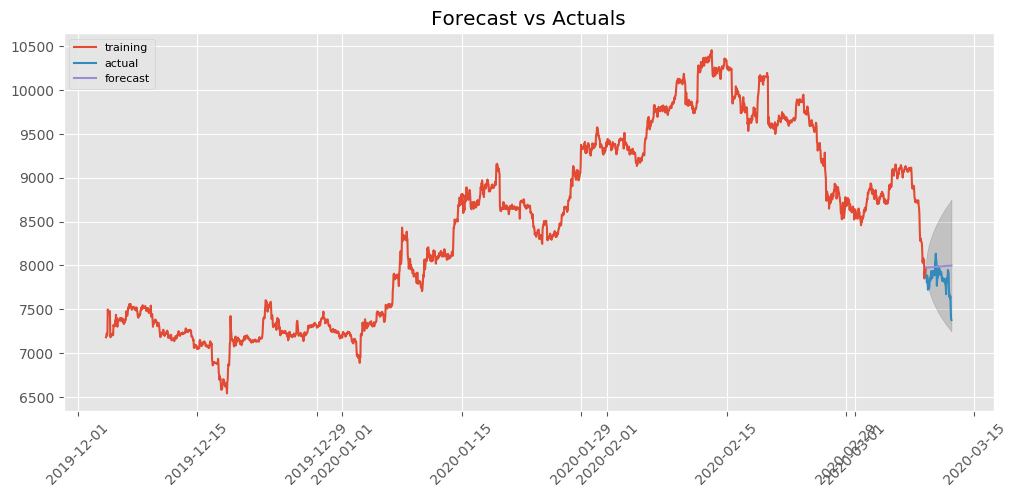

In [45]:
# Build Model
model = ARIMA(train, order=(0, 1, 0))  
model_fit = model.fit()  

# Forecast
fc, se, conf = model_fit.forecast(steps=72, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.xticks(rotation=45)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [46]:
automodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2370
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -12424.092
Date:                Tue, 17 Mar 2020   AIC                          24860.185
Time:                        14:48:29   BIC                          24894.806
Sample:                             0   HQIC                         24872.788
                               - 2370                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0572      3.277      0.017      0.986      -6.365       6.480
ar.L1         -1.6398      0.117    -14.052      0.000      -1.869      -1.411
ar.L2         -0.8293      0.099     -8.382      0.000      -1.023      -0.635
ma.L1          1.6069      0.119     13.532      0.000       1.374       1.840
ma.L2          0.8118      0.099      8.164      0.000       0.617       1.007
sigma2      2102.7971     22.571     93.162      0.000    2058.558    2147.036
===================================================================================
Ljung-Box (Q):                       47.17   Jarque-Bera (JB):             23790.77
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.11   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The P>|z| provides the significance of each feature weight.

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated.

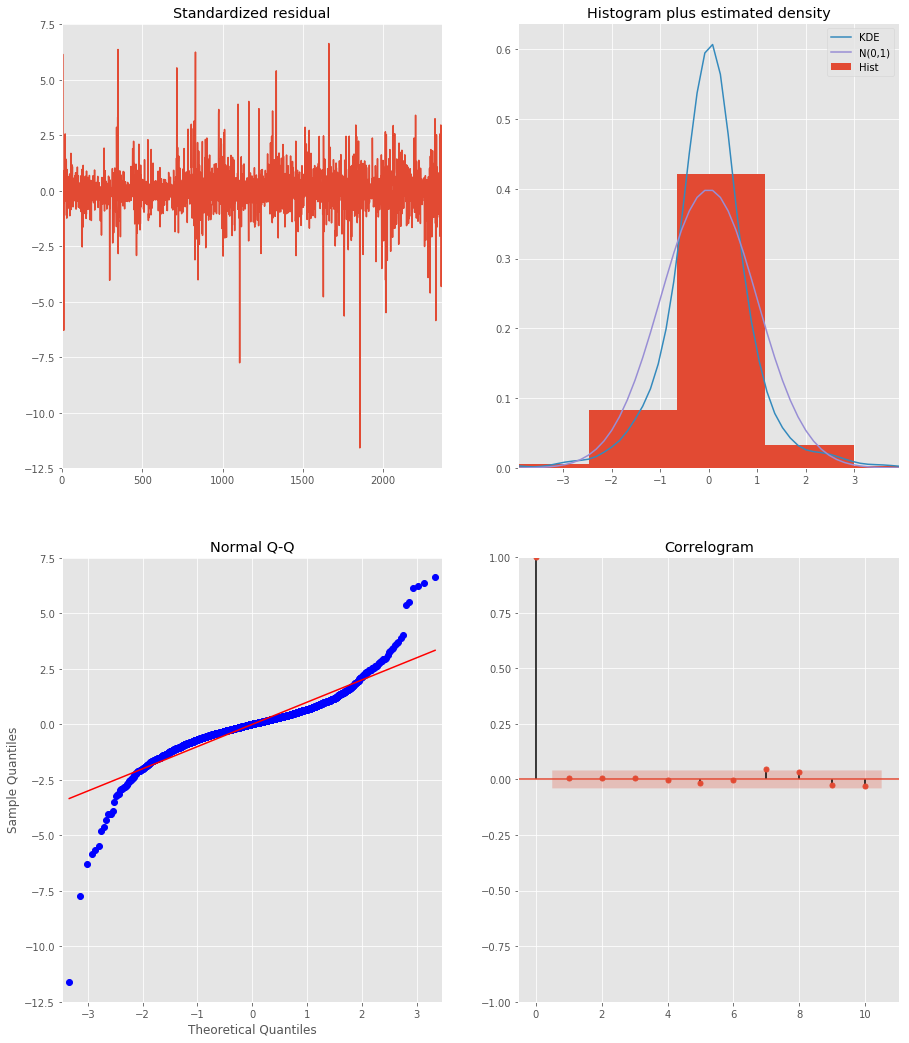

In [47]:
# Call plot_diagnostics() on the results calculated above 
automodel.plot_diagnostics(figsize=(15, 18))
plt.show()

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Let's check for these assumptions from diagnostics plots.

- In the top right plot, we see that the red KDE line follows quite closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed except for the edges where prices are really high or low.

- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [48]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2297
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -12008.440
Method:                           css   S.D. of innovations             45.103
Date:                Tue, 17 Mar 2020   AIC                          24020.880
Time:                        14:48:30   BIC                          24032.359
Sample:                             1   HQIC                         24025.065
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3451      0.941      0.367      0.714      -1.499       2.190


The P>|z| provides the significance of each feature weight.

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

# Final results

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace as of 2020-03-12 09:00:00.

As we forecast further out into the future, it is natural for us to become less confident in our values. 

This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

Next we will be using machine learning to see if we can get an accurate prediction of future prices.